Made by Sarah

In [1]:
import torch
import torchvision

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# render the computation graphs
!pip install torchviz
from torchviz import make_dot

     |████████████████████████████████| 51kB 2.4MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=cb2a5101dc89586ac63256078e4db95baa5ea740a260546d51d37ca503ba7bff
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


# Part I: Autograd

Automatic differentiation is one of important developments that allowed machine learning to become computationally feasible and thus widespread. This is one of the clearest and most helpful explanations of automatic differentiation I've encountered: http://colah.github.io/posts/2015-08-Backprop/

Some things to note for the purposes of autograd here:
- variables keep track of what operation produced them and a computation graph of these operations is recorded (variables generated by operations are generally ones which are transformations of earlier inputs and w/r/t which they have partial derivatives which you want to use later)
- reverse-mode differentiation computes the value of $\frac{\partial \text{ output}}{\partial \text{node}}$ for each node in the graph
- this partial derivative corresponds to the influence of a given node on the output in question
- when we call ```backward()```, we are causing all of the contributing partial derivatives to be computed
- the influence of a given node on the output depends only on its influence on its child nodes, which have already been computed (n.b. if this sounds a lot like dynamic programming, that's because it is - see blog post linked above)

In [3]:
A = torch.rand(2, 2, requires_grad=True)
b = torch.rand(2, requires_grad=True)
x = torch.rand(2, requires_grad=True)

y = torch.matmul(A, x) + b
y

tensor([0.5518, 0.7431], grad_fn=<AddBackward0>)

In [4]:
w = x * torch.rand(2, requires_grad=True)
z = w.sum()
print(z)

z.backward()
print(x.grad)

tensor(0.4342, grad_fn=<SumBackward0>)
tensor([0.6444, 0.1550])


In [5]:
print(w.grad)

None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  """Entry point for launching an IPython kernel.


In [6]:
print(w.retain_grad)

<bound method Tensor.retain_grad of tensor([0.4035, 0.0307], grad_fn=<MulBackward0>)>


In [7]:
print(y.grad_fn.next_functions[1][0].variable)
print(b)
print(y.grad_fn.next_functions[0][0].next_functions[0][0].variable)
print(A)

tensor([0.3628, 0.5152], requires_grad=True)
tensor([0.3628, 0.5152], requires_grad=True)
tensor([[0.0142, 0.9098],
        [0.0976, 0.8420]], requires_grad=True)
tensor([[0.0142, 0.9098],
        [0.0976, 0.8420]], requires_grad=True)


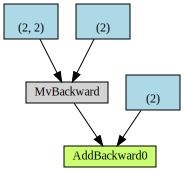

In [8]:
make_dot(y)

In [9]:
# Let's apply a layer module to x:
W = torch.nn.Linear(2, 1)
y_hat = W(x)
y_hat

tensor([-0.1409], grad_fn=<AddBackward0>)

In [10]:
print(W.weight.shape)
print(W.bias.shape)

torch.Size([1, 2])
torch.Size([1])


In [11]:
# stating the action of the layer explicitly:
y = torch.matmul(x, W.weight.T) + W.bias
y

tensor([-0.1409], grad_fn=<AddBackward0>)

y and y_hat have the same computation graph structure (although specifically one uses a permute operation rather than transpose to achieve the same rearrangement):

In [12]:
 print(y_hat.grad_fn.next_functions)
 print(y_hat.grad_fn.next_functions[0][0].next_functions)
 print(y_hat.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)

((<SqueezeBackward3 object at 0x7f310fffaf98>, 0), (<AccumulateGrad object at 0x7f310fffafd0>, 0))
((<MmBackward object at 0x7f310fffafd0>, 0),)
((<UnsqueezeBackward0 object at 0x7f310fffaef0>, 0), (<TBackward object at 0x7f310fffaf98>, 0))


In [13]:
 print(y_hat.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].variable)
 print(y.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].variable)

tensor([0.6262, 0.1980], requires_grad=True)
tensor([0.6262, 0.1980], requires_grad=True)


In [14]:
print(x)

tensor([0.6262, 0.1980], requires_grad=True)


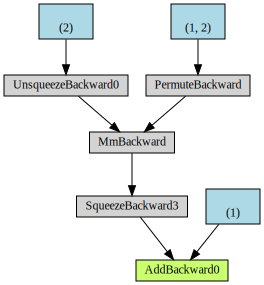

In [15]:
make_dot(y)

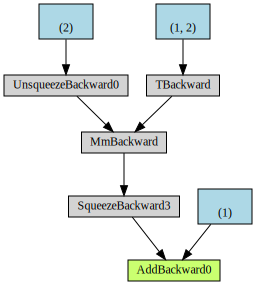

In [16]:
make_dot(y_hat)

In [17]:
print(W.weight.grad) # weights have no gradients yet...

None


In [18]:
y_hat.backward() #...until we call backward()

In [19]:
print(W.weight.grad)

tensor([[0.6262, 0.1980]])


# Part II: Using a dataset

In [20]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw




Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [21]:
# let's try this first without using pinned memory
pinned = False

In [22]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True, pin_memory=pinned)
images, labels = iter(trainDataLoader).next()

In [23]:
class LinearReg(torch.nn.Module):
    def __init__(self):
        super(LinearReg, self).__init__()
        self.linear = torch.nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        transformed_x = self.linear(x) # n.b.: object-oriented API layers are 
        # themselves modules, so when the outer "network" module is called, 
        # this calls the self.forward() methods of its internal modules (layers)
        # recursively
        return transformed_x

In [24]:
net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [25]:
# the weights and biases in net's linear layer are gpu tensors
print(net.linear.weight.device)
print(net.linear.bias.device)

cuda:0
cuda:0


In [26]:
# what device is images on?
images.device

device(type='cpu')

In [27]:
# labels?
labels.device

device(type='cpu')

In [28]:
# move labels to the gpu
labels = labels.cuda()
labels.device

device(type='cuda', index=0)

In [29]:
# let's see what happens when the input to the network is *not* on the gpu:
out = net(images)

# n.b. this has the same result as using the call method net(images)
#out = net.forward(images)

#out = net.linear(images.view(-1, 28*28)) # also same

#out = net.linear.forward(images.view(-1, 28*28)) # also same

In [30]:
out.device # output tensor of the network on a cpu tensor is allocated on the gpu

device(type='cuda', index=0)

In [31]:
out.grad_fn # it has a grad function

In [32]:
# We can assign transformations of it to variables
out = out * 5 # fine, no memory access yet
x = out**2 # also fine

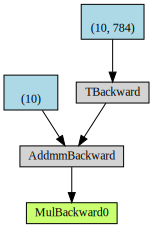

In [33]:
make_dot(out)

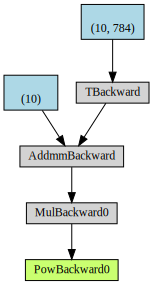

In [34]:
make_dot(x)

These various properties of the ```out``` tensor are defined, but its contents are not, and we haven't encountered an error yet because the computation of the actual values of these operations on ```out``` is delayed until necessary. The following line causes a memory access error on the gpu and you'll have to restart the runtime if you execute it:

In [35]:
#print(x) # illegal memory access in order to get the contents for printing

In [36]:
fit = Loss(out, labels) # fine if labels is already on the gpu, otherwise it's a mismatched devices error

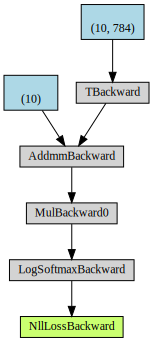

In [37]:
make_dot(fit) # computation graph makes sense

# also note the logsoftmax + NLL loss ops combined in the CrossEntropyLoss 
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [38]:
fit.backward() # oh no!

RuntimeError: ignored

Calling ```backward()``` finally requires the specific contents of the original input, so as soon as this operation is attempted it causes illegal memory access. This has also now caused a failed assertion on the gpu and the device needs to be reinitialized before the host can synchronize with it again, so if we try to perform more operations on the gpu, we will keep having errors about illegal memory access...

In [39]:
newnet = LinearReg().cuda()

#output = net(torch.rand(64, 1, 28, 28, device='cuda:0')) # this also doesn't work

RuntimeError: ignored

...until we restart the runtime, which calls ```cudaDeviceReset()``` and reinitializes the device. Note that it's a good idea to use "Factory reset runtime" to make sure all data and errors are completely cleared (and you should do that here before you try to run the code below).

TL;DR: if we go back to where we created the data loader, change ```pinned = True``` so the attribute ```pin_memory=True```, the devices will use shared memory and we avoid issues with mixing tensors:

In [ ]:
out = net(images)

In [ ]:
fit = Loss(out, labels)

In [ ]:
fit.backward()

In [ ]:
out